Resources:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from clean_images import ImageClense
from clean_tabular import TabularCleanse
from PIL import Image
import os
from numpy import asarray
from PIL import UnidentifiedImageError

tabular_cleanse = TabularCleanse('fb_marketplace_conn.json', 'aicore2022!')
links =  pd.read_csv('/home/adamw/Documents/AiCore/fb_marketplace/images_fb/Links.csv')
img_tabular = tabular_cleanse.get_data_table('images')
img_tabular.drop(['bucket_link',	'image_ref', 'create_time'], axis=1, inplace=True)
directory = os.path.join(os.getcwd(),'images_fb/clean_images/original/')
img_list = []
file_names = []
for file in os.listdir(directory):
    try:
        img = Image.open(os.path.join(directory, file))
        img = asarray(img)
    except UnidentifiedImageError:
        img = None
    img_list.append(img)
    file_name = file.replace('.jpg', '')
    file_names.append(file_name)
img_dict = {
    'id': file_names,
    'img_array': img_list
}
img_data = pd.DataFrame(img_dict, columns=['id', 'img_array'])
img_data =  img_data.dropna(subset=['img_array'])
img_data = pd.merge(img_data, img_tabular, how='left', on='id')
# 62 rows with images in zip file but not in image database
img_data = img_data.dropna(subset=['product_id'])




Prepare list of products to include in classficiation
###### This is based on the same data included in the tabular classification

In [2]:
products = pd.read_pickle('final_cleaned_products.pkl')
products = products.dropna(subset='long')
products = tabular_cleanse.remove_rows_conditonal(products, 'price_gbp', 1000.00, '<')
products.drop(['location'], axis=1, inplace=True)
# Drop the cat0 fields to test the model
# Consider that dummy encodign has been applied and therefore on of the clasesses is missing.
# https://machinelearningmastery.com/types-of-classification-in-machine-learning/
#https://machinelearningmastery.com/discrete-probability-distributions-for-machine-learning/
products = products[products.columns.drop(list(products.filter(regex='cat_1')))]
# This puts category appliances back in as it was removed when cleaning the data using dummy encoding. This was used because i did not want to run the geocoder again due to un time.
categories = list(products.filter(regex='cat_0'))
products['cat_0__Appliances'] = np.where(products[categories].sum(axis=1) == 0, 1, 0)
Applicances = products.pop('cat_0__Appliances')
products.insert(4,'cat_0__Appliances', Applicances)
# k-Nearest Neighbors.
# Decision Trees.
# Naive Bayes.
# Random Forest.
# Gradient Boosting.
products.sum()

id                                          243809c0-9cfc-4486-ad12-3b7a16605ba91c58d3f9-8...
price_gbp                                                                            736256.0
long                                                                            344014.976773
lat                                                                             -22414.651779
cat_0__Appliances                                                                         494
cat_0__Baby & Kids Stuff                                                                  392
cat_0__Clothes, Footwear & Accessories                                                    368
cat_0__Computers & Software                                                               547
cat_0__DIY Tools & Materials                                                              505
cat_0__Health & Beauty                                                                    566
cat_0__Home & Garden                                        

In [3]:
model_data = pd.merge(img_data, products, how='right', left_on='product_id', right_on='id', suffixes=('', '_dupe')).filter(regex='^(?!.*_dupe)')
# model_data.info()
model_data = model_data.dropna(subset=['img_array'])
model_data

,id,img_array,product_id,price_gbp,long,lat,cat_0__Appliances,cat_0__Baby & Kids Stuff,"cat_0__Clothes, Footwear & Accessories",cat_0__Computers & Software,cat_0__DIY Tools & Materials,cat_0__Health & Beauty,cat_0__Home & Garden,"cat_0__Music, Films, Books & Games",cat_0__Office Furniture & Equipment,cat_0__Other Goods,"cat_0__Phones, Mobile Phones & Telecoms","cat_0__Sports, Leisure & Travel",cat_0__Video Games & Consoles
0,64aa79f3-e9fa-417c-a332-714b8ce933f1,"[[[4, 0, 0], [1, 0, 0], [0, 0, 2], [0, 1, 4], ...",243809c0-9cfc-4486-ad12-3b7a16605ba9,5.0,51.453489,-1.031873,0,0,0,0,0,0,1,0,0,0,0,0,0
1,a864ee52-d91e-46e7-94d1-2418e9bb2877,"[[[255, 246, 237], [255, 249, 244], [255, 251,...",1c58d3f9-8b93-47ea-9415-204fcc2a22e6,20.0,57.479012,-4.225739,0,0,0,0,0,0,1,0,0,0,0,0,0
2,4e670f9e-7feb-458f-b529-ac52547abe2b,"[[[255, 249, 242], [255, 249, 242], [255, 250,...",1c58d3f9-8b93-47ea-9415-204fcc2a22e6,20.0,57.479012,-4.225739,0,0,0,0,0,0,1,0,0,0,0,0,0
3,bfe77c38-c9eb-47fb-b3d6-31ffdefb6ff9,"[[[3, 0, 0], [1, 0, 0], [0, 0, 5], [0, 2, 11],...",860673f1-57f6-47ba-8d2f-13f9e05b8f9a,20.0,53.150228,0.329093,0,0,0,0,0,0,1,0,0,0,0,0,0
4,a92e56b7-94fc-41b4-ba6c-f2f224f42bb8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",59948726-29be-4b35-ade5-bb2fd7331856,115.0,51.291949,-2.447623,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11737,99374787-d4b4-4264-980c-954123446777,"[[[3, 0, 0], [1, 0, 0], [1, 0, 0], [0, 0, 0], ...",88d2d66b-2685-46b8-af84-f495fd2ccb14,380.0,53.450693,-2.994883,0,0,0,0,0,0,0,0,0,0,0,0,1
11738,bcc22d62-5285-4fbc-bbe0-d75259dbff71,"[[[0, 5, 0], [0, 2, 0], [1, 0, 9], [6, 0, 7], ...",8ca91ce8-49e7-4746-b06c-ac838d94ef35,650.0,53.485152,-2.898906,0,0,0,0,0,0,0,0,0,0,0,0,1
11739,04722d18-acac-4d7a-8eec-6171c064d382,"[[[0, 0, 7], [1, 0, 0], [3, 0, 0], [3, 0, 5], ...",8ca91ce8-49e7-4746-b06c-ac838d94ef35,650.0,53.485152,-2.898906,0,0,0,0,0,0,0,0,0,0,0,0,1
11740,c05faddc-9ae7-4043-8b39-62ff1e3bfcfe,"[[[1, 5, 4], [0, 2, 1], [0, 1, 0], [0, 1, 0], ...",df8ef910-03cc-4c9e-97a9-7f0a7e838102,10.0,51.272337,-0.721647,0,0,0,0,0,0,0,0,0,0,0,0,1


In [4]:
flatten_list = []
for i in model_data['img_array']:
    if type(i) is np.ndarray:
        flatten_list.append(i.flatten())
    else:
        flatten_list.append(None)

model_data['flatten_img_array'] = flatten_list
model_data





,id,img_array,product_id,price_gbp,long,lat,cat_0__Appliances,cat_0__Baby & Kids Stuff,"cat_0__Clothes, Footwear & Accessories",cat_0__Computers & Software,cat_0__DIY Tools & Materials,cat_0__Health & Beauty,cat_0__Home & Garden,"cat_0__Music, Films, Books & Games",cat_0__Office Furniture & Equipment,cat_0__Other Goods,"cat_0__Phones, Mobile Phones & Telecoms","cat_0__Sports, Leisure & Travel",cat_0__Video Games & Consoles,flatten_img_array
0,64aa79f3-e9fa-417c-a332-714b8ce933f1,"[[[4, 0, 0], [1, 0, 0], [0, 0, 2], [0, 1, 4], ...",243809c0-9cfc-4486-ad12-3b7a16605ba9,5.0,51.453489,-1.031873,0,0,0,0,0,0,1,0,0,0,0,0,0,"[4, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 4, 0, 1, 5, ..."
1,a864ee52-d91e-46e7-94d1-2418e9bb2877,"[[[255, 246, 237], [255, 249, 244], [255, 251,...",1c58d3f9-8b93-47ea-9415-204fcc2a22e6,20.0,57.479012,-4.225739,0,0,0,0,0,0,1,0,0,0,0,0,0,"[255, 246, 237, 255, 249, 244, 255, 251, 253, ..."
2,4e670f9e-7feb-458f-b529-ac52547abe2b,"[[[255, 249, 242], [255, 249, 242], [255, 250,...",1c58d3f9-8b93-47ea-9415-204fcc2a22e6,20.0,57.479012,-4.225739,0,0,0,0,0,0,1,0,0,0,0,0,0,"[255, 249, 242, 255, 249, 242, 255, 250, 243, ..."
3,bfe77c38-c9eb-47fb-b3d6-31ffdefb6ff9,"[[[3, 0, 0], [1, 0, 0], [0, 0, 5], [0, 2, 11],...",860673f1-57f6-47ba-8d2f-13f9e05b8f9a,20.0,53.150228,0.329093,0,0,0,0,0,0,1,0,0,0,0,0,0,"[3, 0, 0, 1, 0, 0, 0, 0, 5, 0, 2, 11, 0, 3, 14..."
4,a92e56b7-94fc-41b4-ba6c-f2f224f42bb8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",59948726-29be-4b35-ade5-bb2fd7331856,115.0,51.291949,-2.447623,0,0,0,0,0,0,1,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11737,99374787-d4b4-4264-980c-954123446777,"[[[3, 0, 0], [1, 0, 0], [1, 0, 0], [0, 0, 0], ...",88d2d66b-2685-46b8-af84-f495fd2ccb14,380.0,53.450693,-2.994883,0,0,0,0,0,0,0,0,0,0,0,0,1,"[3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11738,bcc22d62-5285-4fbc-bbe0-d75259dbff71,"[[[0, 5, 0], [0, 2, 0], [1, 0, 9], [6, 0, 7], ...",8ca91ce8-49e7-4746-b06c-ac838d94ef35,650.0,53.485152,-2.898906,0,0,0,0,0,0,0,0,0,0,0,0,1,"[0, 5, 0, 0, 2, 0, 1, 0, 9, 6, 0, 7, 7, 0, 0, ..."
11739,04722d18-acac-4d7a-8eec-6171c064d382,"[[[0, 0, 7], [1, 0, 0], [3, 0, 0], [3, 0, 5], ...",8ca91ce8-49e7-4746-b06c-ac838d94ef35,650.0,53.485152,-2.898906,0,0,0,0,0,0,0,0,0,0,0,0,1,"[0, 0, 7, 1, 0, 0, 3, 0, 0, 3, 0, 5, 1, 0, 7, ..."
11740,c05faddc-9ae7-4043-8b39-62ff1e3bfcfe,"[[[1, 5, 4], [0, 2, 1], [0, 1, 0], [0, 1, 0], ...",df8ef910-03cc-4c9e-97a9-7f0a7e838102,10.0,51.272337,-0.721647,0,0,0,0,0,0,0,0,0,0,0,0,1,"[1, 5, 4, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 4, 0, ..."


In [8]:
model_data = model_data.sample(frac=0.01, random_state=42)
model_data

,id,img_array,product_id,price_gbp,long,lat,cat_0__Appliances,cat_0__Baby & Kids Stuff,"cat_0__Clothes, Footwear & Accessories",cat_0__Computers & Software,cat_0__DIY Tools & Materials,cat_0__Health & Beauty,cat_0__Home & Garden,"cat_0__Music, Films, Books & Games",cat_0__Office Furniture & Equipment,cat_0__Other Goods,"cat_0__Phones, Mobile Phones & Telecoms","cat_0__Sports, Leisure & Travel",cat_0__Video Games & Consoles,flatten_img_array
6119,dddd4d95-bcfc-4550-8a2a-9560a9023d51,"[[[132, 138, 126], [138, 144, 132], [140, 146,...",49e5b00b-dffc-42cf-ad47-913c0aa16f81,20.00,51.061610,-2.754857,0,0,0,0,0,0,0,1,0,0,0,0,0,"[132, 138, 126, 138, 144, 132, 140, 146, 134, ..."
8178,c26d58d9-91d9-4112-9c35-b50b1bf67ce4,"[[[169, 71, 96], [169, 65, 92], [176, 61, 92],...",bcc8ee8c-3319-406f-ac64-d6c04c8bb2d0,4.00,51.347193,-2.977892,0,0,0,0,0,0,0,0,0,0,1,0,0,"[169, 71, 96, 169, 65, 92, 176, 61, 92, 188, 6..."
3698,56fa219f-92a1-4a0e-960b-72f5307d4319,"[[[202, 220, 234], [202, 220, 234], [202, 220,...",8f7fa73a-d738-4051-92e7-7711043c825b,650.00,51.783885,-1.485286,0,0,0,0,0,0,0,0,0,0,0,1,0,"[202, 220, 234, 202, 220, 234, 202, 220, 234, ..."
6923,10f341b5-2960-43d7-98fa-0ccf761a5687,"[[[100, 83, 67], [90, 73, 57], [83, 66, 50], [...",2a684561-dc86-459d-bc51-bc2425cb702c,0.01,52.057949,1.152635,0,0,0,0,0,0,0,1,0,0,0,0,0,"[100, 83, 67, 90, 73, 57, 83, 66, 50, 86, 69, ..."
10302,2011ff95-f9ad-4b19-9fc1-cb0ded1967af,"[[[193, 211, 197], [193, 211, 197], [193, 211,...",44a5c7f8-c9d5-471f-9d2e-47ee0dd62374,10.00,52.636140,-1.133079,0,0,0,0,0,0,0,0,1,0,0,0,0,"[193, 211, 197, 193, 211, 197, 193, 211, 197, ..."
5792,14c18b9d-ffc7-4d5d-870f-dccd8cdd4102,"[[[8, 9, 13], [36, 37, 41], [146, 147, 149], [...",90f7bb12-da35-4a9b-b15a-95488444d803,60.00,53.707437,-1.675450,1,0,0,0,0,0,0,0,0,0,0,0,0,"[8, 9, 13, 36, 37, 41, 146, 147, 149, 138, 138..."
764,68eabed7-fd6c-43da-ae39-d3fe218eff78,"[[[93, 90, 71], [95, 92, 73], [99, 96, 77], [1...",e391cb7a-5b7f-4f0a-a4db-b57c8ba0a4f2,30.00,55.856009,-4.243251,0,0,0,0,0,0,1,0,0,0,0,0,0,"[93, 90, 71, 95, 92, 73, 99, 96, 77, 102, 99, ..."
9083,334acc96-ed5a-43a5-8690-4ca801f66649,"[[[243, 167, 115], [245, 175, 126], [235, 172,...",98008111-abcf-4ca5-a588-04553b85bb92,375.00,51.536468,-3.140719,0,0,0,0,0,1,0,0,0,0,0,0,0,"[243, 167, 115, 245, 175, 126, 235, 172, 129, ..."
99,d965ba6a-4424-43b1-96e9-de6ad5095ca3,"[[[51, 46, 40], [61, 56, 50], [74, 69, 63], [8...",cedbf235-b6e4-4a54-98c6-6a02e6aeba52,50.00,51.474571,-0.092542,0,0,0,0,0,0,1,0,0,0,0,0,0,"[51, 46, 40, 61, 56, 50, 74, 69, 63, 86, 81, 7..."
6702,1bc4f786-90f8-4b94-b3fd-b129be2c08f0,"[[[126, 109, 89], [114, 97, 77], [112, 95, 75]...",773f152b-90f5-44b8-8491-340271db9458,2.00,51.544951,-0.481667,0,0,0,0,0,0,0,1,0,0,0,0,0,"[126, 109, 89, 114, 97, 77, 112, 95, 75, 113, ..."


In [5]:
value = model_data['flatten_img_array'].isnull().values.any()
value

False

In [90]:
from sklearn.preprocessing import LabelEncoder
# X = model_data[['flatten_img_array', 'price_gbp', 'long', 'lat']]
X = list(model_data['flatten_img_array'])
y = model_data.filter(regex='cat_0')
le = LabelEncoder()
y_labels = y.idxmax(axis=1)
label = list(le.fit_transform(y_labels))
y['category']= label
y['labels'] = y_labels
label_lookup = y[['category', 'labels']].copy()
label_lookup = label_lookup.groupby(['category', 'labels'])['category'].count()
y = y.filter(regex='category')
y = list(y['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_216773/3346439960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['category']= label
/tmp/ipykernel_216773/3346439960.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['labels'] = y_labels


In [91]:
dimensions = set([len(i) for i in X])
print(dimensions)

{12288}


In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(penalty='none', 
                         tol=0.1, solver='saga',
                         multi_class='multinomial')

In [93]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler to train set - which means it identifies the values for scaling only on the training set and stores this in the scaler
scaler.fit(X_train)
# The scaler can now be applied to the train, validation and test sets which holds the info from the train set only
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [94]:
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
log_reg.fit(X_train, y_train)


LogisticRegression(multi_class='multinomial', penalty='none', solver='saga',
                   tol=0.1)

In [46]:
y_pred = log_reg.predict(X_test)
# summarize the predicted class
print(y_test[22])
print('Predicted Class: %d' % y_pred[22])

4
Predicted Class: 0


In [95]:
score = log_reg.score(X_test, y_test)
print(score)
print(len(y_test))

0.18462859596393302
2329


In [96]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[ 26   2   9  21   9   8  55  10  14   5   5   5   2]
 [ 13   4  17  15   5   8  32  18   5   4   6   9   6]
 [  7   6  20  12  11   8  43  11   3   6  11   5   2]
 [ 13   5   7  60   7   8  40  17  18   1   5   7   7]
 [ 13   1   2  13  19  10  61  16  10   7  10   1   1]
 [ 16   8   7  19   9  28  52  24  13   9   9   3   8]
 [ 20   4   9  12  14  20 126  30  25  11   9   7   2]
 [  3   5  11  21  10   9  65  48   9   7   3   2   7]
 [ 16   0  13  18  10   7  63  18  41   4   6   7   5]
 [ 10   3   9  12   5   9  55  25  16  14   5   2   5]
 [ 14   4  10   9   8  16  23  14   6   3  27   3   3]
 [  5   1   8  14   7  16  68   7  12   8   2  10   0]
 [ 12   1   4  23   6  12  30  17   9   6  10   4   8]]


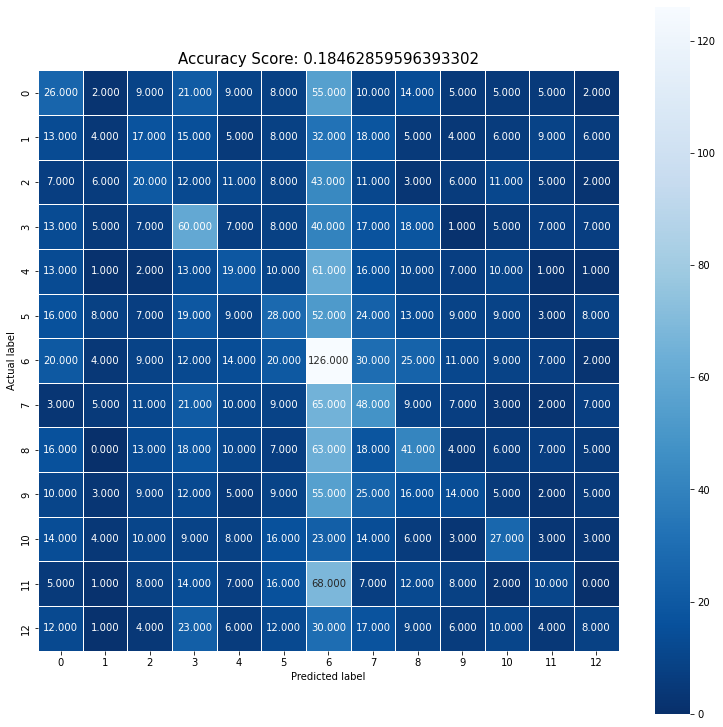

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.show()

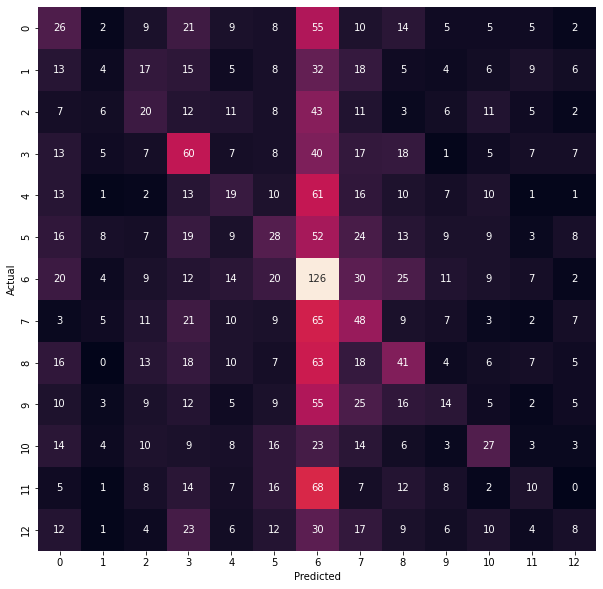

In [98]:
cm = pd.crosstab(y_test, y_pred, 
                               rownames=['Actual'], colnames=['Predicted'])
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt="d", cbar=False)

category  labels                                  
0         cat_0__Appliances                            867
1         cat_0__Baby & Kids Stuff                     682
2         cat_0__Clothes, Footwear & Accessories       691
3         cat_0__Computers & Software                 1003
4         cat_0__DIY Tools & Materials                 871
5         cat_0__Health & Beauty                       999
6         cat_0__Home & Garden                        1409
7         cat_0__Music, Films, Books & Games           987
8         cat_0__Office Furniture & Equipment          981
9         cat_0__Other Goods                           841
10        cat_0__Phones, Mobile Phones & Telecoms      714
11        cat_0__Sports, Leisure & Travel              794
12        cat_0__Video Games & Consoles                804
Name: category, dtype: int64

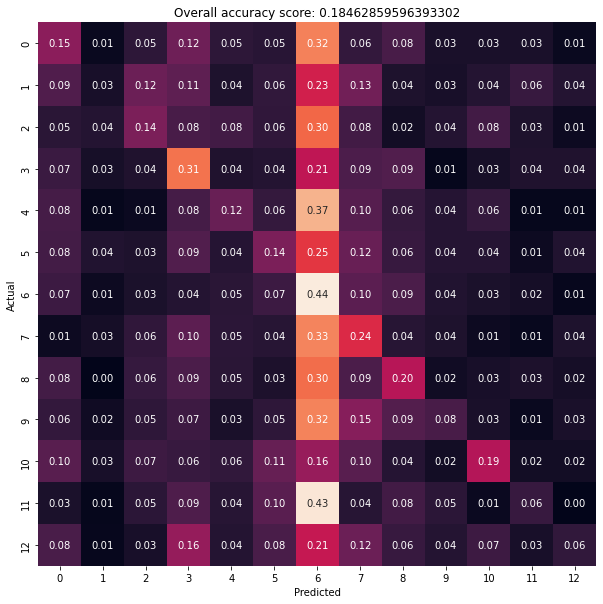

In [102]:
cm = pd.crosstab(y_test, y_pred, 
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)
p.set_title(f'Overall accuracy score: {score}')
label_lookup.head(13)